In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('df-scaling.pkl')
df['Response'] = df['Response'].apply(lambda x: 1 if x == 2.371150879945913 else -1)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Response'], axis = 1), df['Response'],
                                                    random_state=42)

## Линейная классификация

In [3]:
from sklearn.base import BaseEstimator

def log_loss(X, y, w = None):
    """
    Логистическая функция потерь
    :param w: Веса классификатора
    :param X: Массив данных
    :param y: Целевая логическая переменная
    :return: Значение функции потерь
    """
    X = np.array(X)
    y = np.array(y)
    if w is None:
        w = np.zeros(X.shape[1])

    Q = np.log(1 + np.exp(-y * (X @ w))).mean()
    return Q

def gradient(X, y, w = None):
    """
    Градиент функции потерь
    :param X: Массив данных
    :param y: Целевая логическая переменная
    :param w: Веса классификатора
    :return: Значение антиградиента
    """
    X = np.array(X)
    y = np.array(y)
    if w is None:
        w = np.zeros(X.shape[1])

    Q_grad = - ((X * y.reshape(-1, 1)) / (1 + np.exp(y * (X @ w))).reshape(-1, 1)).mean(axis=0)
    return Q_grad


class LineClassifier(BaseEstimator):
    def __init__(self, max_iter = 1000, eta = 0.2):
        """
        :param max_iter: Максимальное количество итераций градиентного спуска
        :param eta: Шаг для каждой итерации градиентного спуска
        """
        self.loss_array = None
        self.w = None
        self.max_iter = max_iter
        self.eta = eta

    def fit(self, X, y, w = None):
        """
        Обучение градиентного спуска
        :param X: Массив данных
        :param y: Целевая логическая переменная
        :param w: Начальные веса классификатора
        :return: Итоговые веса классификатора и вектор значений логистических функций потерь
        """
        X = np.array(X)
        y = np.array(y)
        if w is None:
            w = np.zeros(X.shape[1])

        loss_array = [log_loss(X, y, w)]
        for _ in range(self.max_iter):
            w_grad = gradient(X, y, w)
            w -= self.eta * w_grad
            loss = log_loss(X, y, w)
            loss_array.append(loss)
            
        self.w = w
        self.loss_array = loss_array

    def predict(self, X):
        """
        Прогнозирование целевой переменной
        :param X: Массив данных
        :return: Предсказание целевой переменной
        """
        X = np.array(X)
        return np.sign(X @ self.w)

    def predict_probabilities(self, X, threshold = None):
        """
        Вероятности получить положительный ответ через сигмойдную функцию
        :param X: Массив данных
        :param threshold: порог вероятности для определения положительного ответа
        :return: Вектор вероятностей получить положительный ответ
        """
        y_prob = 1 / (1 + np.exp(-X @ self.w))
        if threshold is not None:
            y_prob[y_prob > threshold] = 1
            y_prob[y_prob <= threshold] = -1
        return y_prob

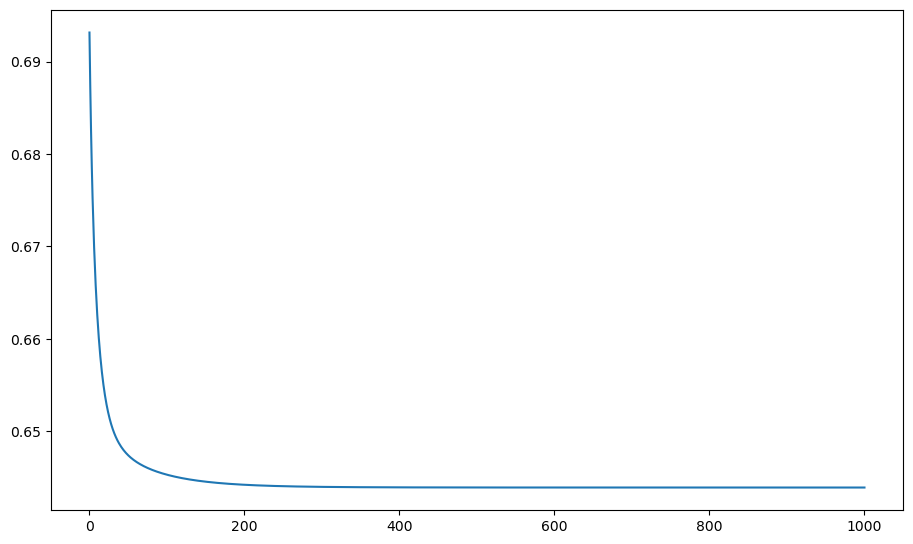

In [4]:
lc = LineClassifier()
lc.fit(X_train, y_train)

plt.figure(figsize=(11, 6.5))
plt.plot(lc.loss_array)

In [5]:
y_predict = lc.predict(X_test)

from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, confusion_matrix

print(f"""
Доля правильных ответов :{accuracy_score(y_test, y_predict)}
Точность :{precision_score(y_test, y_predict)}
Полнота :{recall_score(y_test, y_predict)}
F-мера :{fbeta_score(y_test, y_predict, beta=2)}

Матрица ошибок:
{confusion_matrix(y_test, y_predict)}
""")


Доля правильных ответов :0.6405109489051095
Точность :0.28076923076923077
Полнота :0.8795180722891566
F-мера :0.6165540540540541

Матрица ошибок:
[[278 187]
 [ 10  73]]



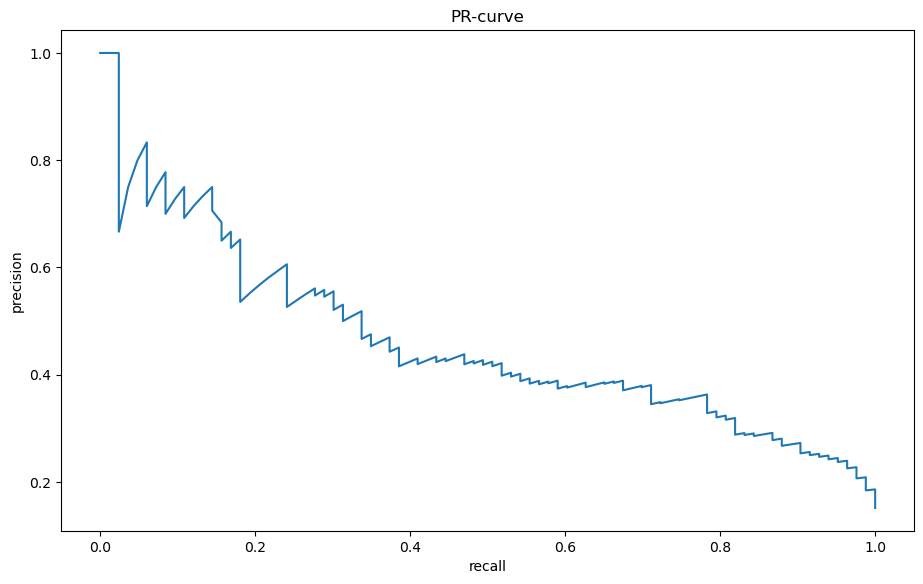

In [6]:
y_predict_prob = lc.predict_probabilities(X_test)

from sklearn.metrics import precision_recall_curve
precision_array, recall_array, thresholds = precision_recall_curve(y_test, y_predict_prob)
plt.figure(figsize=(11, 6.5))
plt.plot(recall_array, precision_array)
plt.title('PR-curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

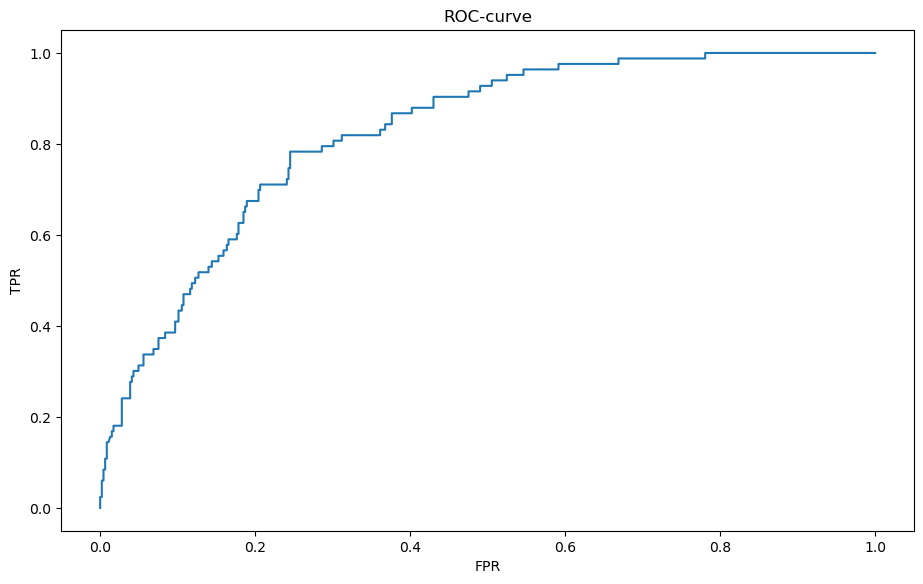

In [7]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_predict_prob)
plt.figure(figsize=(11, 6.5))
plt.plot(fpr, tpr)
plt.title('ROC-curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [8]:
gradient(X_train, y_train)

array([-0.04012389, -0.04272547, -0.05906064,  0.07473972,  0.00055966,
       -0.01111348,  0.01279557, -0.0742862 , -0.09227267, -0.0577655 ])